In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#just my usual imports that i essentialy do for all my projects, dont need all of em but hey i'm lazy to comment em out 
import tensorflow as tf 
import numpy as np 
from tensorflow import keras
import os 
import random 
import cv2
import matplotlib.pyplot as plt
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import plot_model 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
data_dir = r"/content/drive/MyDrive/A-Dataset-for-Automatic-Violence-Detection-in-Videos-master"
img_height , img_width = 90, 90
seq_len = 25
embed_dim = 2048
dense_dim = 4
num_heads = 1 

In [ ]:
classes = ["non-violent","violent"]


In [ ]:

X = X.astype("float32") / 255.0

In [ ]:
X.shape

(291, 50, 90, 90, 3)

In [ ]:
np.random.seed(1337)

In [ ]:
X= np.load('/content/drive/MyDrive/428/violance_X.npy')
Y=np.load('/content/drive/MyDrive/428/violance_Y.npy')

In [ ]:
print(np.amax(X[0]))

1.0


In [ ]:
epochs=50
opt = keras.optimizers.SGD(lr=0.001 ,momentum = 0.9, decay = 1e-4/epochs)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

## CNN-transformer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=0)

In [ ]:
# MODEL

class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
    self.sequence_length = sequence_length
    self.output_dim = output_dim
  
  def call(self, inputs):
    length = tf.shape(inputs)[1]
    positions =tf.range(start=0, limit=length, delta=1)
    embedded_positions = self.position_embeddings(positions)
    return inputs + embedded_positions

  def compute_mask(self, inputs, mask=None):
    mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.3)
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask=None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(inputs, inputs, attention_mask = mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

In [ ]:
def cnnModel(seqLen=seq_len,embedDim=2048,numHeads=8,frameSize=(img_height,img_width),dense_dim = 4,dense_dim2=8):
  inputs = keras.Input(shape=(seq_len,img_height,img_width,3))
  x=layers.TimeDistributed(layers.Conv2D(256,3,activation='relu'))(inputs)
  x=layers.TimeDistributed(layers.Conv2D(256,3,activation='relu'))(x)
  x=layers.TimeDistributed(layers.MaxPooling2D())(x)
  x=layers.TimeDistributed(layers.Conv2D(128,3,activation='relu'))(x)
  x=layers.TimeDistributed(layers.Conv2D(64,3,activation='relu'))(x)
  x=layers.TimeDistributed(layers.GlobalMaxPooling2D())(x)
  x = PositionalEmbedding(seq_len,np.shape(x)[-1], name="frame_position_embedding")(x)

  x = TransformerEncoder(np.shape(x)[-1], dense_dim, num_heads, name="transformer_layer")(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(2, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
frameSize=(90,90)
numHeads=8
dense_dim2=8

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
epochs=50

In [ ]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5 
epochs=50

In [ ]:

model = cnnModel(seqLen=seq_len,embedDim=embed_dim,numHeads=numHeads,frameSize=frameSize,dense_dim = dense_dim,dense_dim2=dense_dim2)


# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
optimizer=optimizer,
loss="categorical_crossentropy",
metrics=["accuracy"

],
)

# Train the model.
history = model.fit(x = X_train, y = y_train, epochs=epochs, batch_size = 8 , shuffle=True, validation_split=0.1, callbacks=callbacks)




    



Epoch 1/50
30/30 [==============================] - 61s 1s/step - loss: 1.1614 - accuracy: 0.5812 - val_loss: 0.7932 - val_accuracy: 0.4444
Epoch 2/50
30/30 [==============================] - 36s 1s/step - loss: 0.7920 - accuracy: 0.5855 - val_loss: 0.6529 - val_accuracy: 0.7037
Epoch 3/50
30/30 [==============================] - 37s 1s/step - loss: 0.6921 - accuracy: 0.6111 - val_loss: 0.6986 - val_accuracy: 0.5185
Epoch 4/50
30/30 [==============================] - 37s 1s/step - loss: 0.6630 - accuracy: 0.6325 - val_loss: 0.6187 - val_accuracy: 0.7778
Epoch 5/50
30/30 [==============================] - 38s 1s/step - loss: 0.6659 - accuracy: 0.6154 - val_loss: 0.5961 - val_accuracy: 0.8148
Epoch 6/50
30/30 [==============================] - 38s 1s/step - loss: 0.6354 - accuracy: 0.6752 - val_loss: 0.7263 - val_accuracy: 0.5185
Epoch 7/50
30/30 [==============================] - 39s 1s/step - loss: 0.5692 - accuracy: 0.7308 - val_loss: 0.6762 - val_accuracy: 0.5185
Epoch 8/50
30/30 [==

In [ ]:
transformer_score= model.evaluate(X_test,y_test, batch_size=8, verbose=2)

4/4 - 4s - loss: 0.6906 - accuracy: 0.7667 - 4s/epoch - 1s/step


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)


y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [ ]:
history_loss, history_accuracy =transformer_score

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = history.history[metric_name_1]
  metric_value_2 = history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

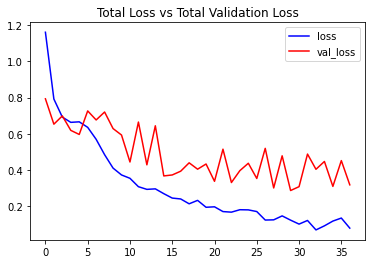

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

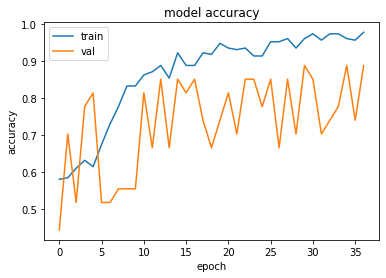

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

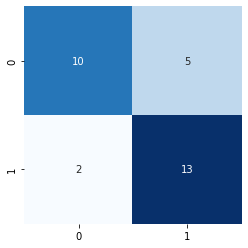

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

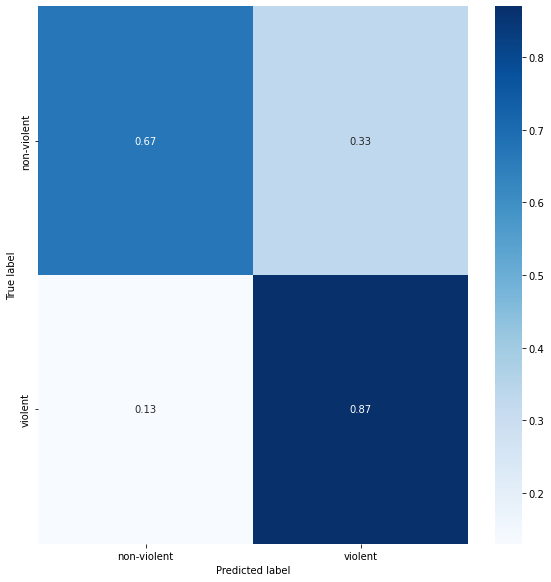

In [ ]:
import pandas as pd
y_true=y_test
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/saved model/transformer.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


NotImplementedError: ignored

In [ ]:
    x=keras.applications.densenet.preprocess_input(inputs)
    # inc=InceptionV3(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
    inc=keras.applications.DenseNet121(weights="imagenet",include_top=False,  pooling="max",input_shape=(frameSize[0],frameSize[1],3))
    # inc=tf.keras.applications.ResNet152V2(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
    # inc=tf.keras.applications.DenseNet121(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
    # inc.fc=layers.Dense(embedDim,activation=tf.nn.gelu)#is this line the issue?
    for layer in inc.layers:
      layer.trainable=False
    x=layers.TimeDistributed(inc)(x)#out is 3D

In [ ]:
def denseModel(seqLen=seq_len,embedDim=2048,numHeads=8,frameSize=(img_height,img_width),dense_dim = 4,dense_dim2=8):
  
  inputs = keras.Input(shape=(seq_len,img_height,img_width,3))
  x=keras.applications.densenet.preprocess_input(inputs)
  # inc=InceptionV3(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
  inc=keras.applications.DenseNet121(weights="imagenet",include_top=False,  pooling="max",input_shape=(img_height,img_width,3))
  # inc=tf.keras.applications.ResNet152V2(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
  # inc=tf.keras.applications.DenseNet121(include_top=False, pooling='avg',input_shape=(frameSize[0],frameSize[1],3))
  # inc.fc=layers.Dense(embedDim,activation=tf.nn.gelu)#is this line the issue?
  for layer in inc.layers:
    layer.trainable=False
  x=layers.TimeDistributed(inc)(x)#out is 3D
  x = PositionalEmbedding(seq_len,np.shape(x)[-1], name="frame_position_embedding")(x)

  x = TransformerEncoder(np.shape(x)[-1], dense_dim, num_heads, name="transformer_layer")(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(2, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
model = denseModel(seqLen=seq_len,embedDim=embed_dim,numHeads=numHeads,frameSize=frameSize,dense_dim = dense_dim,dense_dim2=dense_dim2)


# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
optimizer=optimizer,
loss="categorical_crossentropy",
metrics=["accuracy"

],
)

# Train the model.
history = model.fit(x = X_train, y = y_train, epochs=epochs, batch_size = 8 , shuffle=True, validation_split=0.1, callbacks=callbacks)


Epoch 1/50
30/30 [==============================] - 15s 229ms/step - loss: 1.0110 - accuracy: 0.5726 - val_loss: 0.9973 - val_accuracy: 0.4444
Epoch 2/50
30/30 [==============================] - 4s 132ms/step - loss: 0.9631 - accuracy: 0.5684 - val_loss: 0.6416 - val_accuracy: 0.7037
Epoch 3/50
30/30 [==============================] - 4s 131ms/step - loss: 0.9825 - accuracy: 0.5427 - val_loss: 0.9095 - val_accuracy: 0.4444
Epoch 4/50
30/30 [==============================] - 4s 132ms/step - loss: 0.9340 - accuracy: 0.5385 - val_loss: 0.6293 - val_accuracy: 0.7407
Epoch 5/50
30/30 [==============================] - 4s 132ms/step - loss: 0.9216 - accuracy: 0.5342 - val_loss: 0.6410 - val_accuracy: 0.6296
Epoch 6/50
30/30 [==============================] - 4s 133ms/step - loss: 0.8203 - accuracy: 0.5684 - val_loss: 0.6441 - val_accuracy: 0.5926
Epoch 7/50
30/30 [==============================] - 4s 141ms/step - loss: 0.7925 - accuracy: 0.6154 - val_loss: 0.5934 - val_accuracy: 0.8148
Epoch

In [ ]:
transformer_score2= model.evaluate(X_test,y_test, batch_size=8, verbose=2)

ValueError: ignored

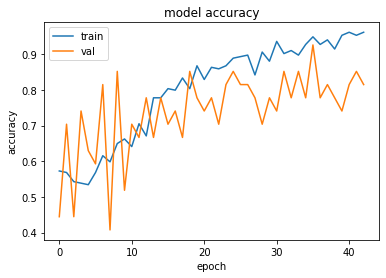

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

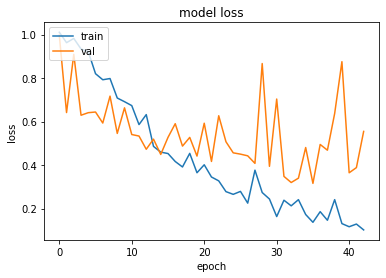

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()